In [1]:
import pandas as pd

<AxesSubplot:>

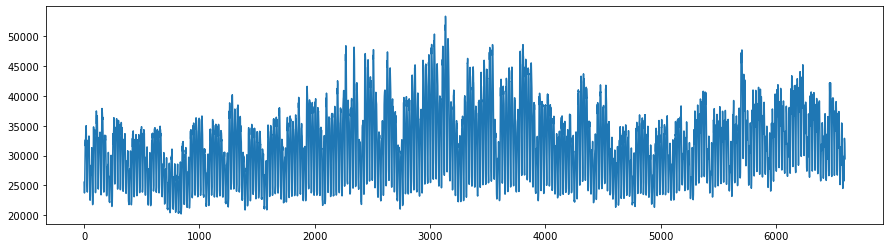

In [2]:
df_kw = pd.read_csv("juyo-2016.csv",encoding="Shift_JIS",skiprows=1)
df_kw["MW"] = df_kw["実績(万kW)"] * 10

df_kw["DATETIME"] = df_kw.index.map(lambda _: pd.to_datetime(df_kw.DATE[_] + " " + df_kw.TIME[_]))

# 可視化
df_kw["MW"].plot(figsize=(15,4))

<AxesSubplot:>

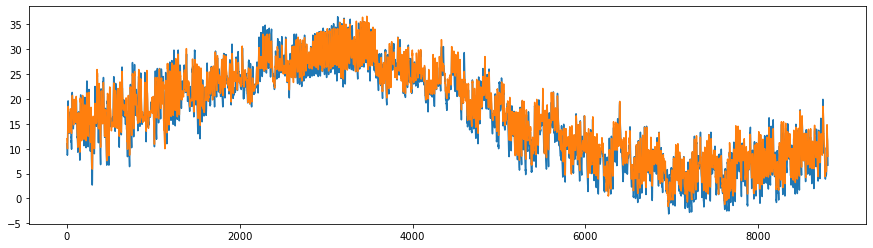

In [4]:
def read_temp(filename):
    df_temp = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_temp.columns = ["DATETIME","TEMP","品質情報","均質番号"]
    df_temp.DATETIME = df_temp.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_temp

# 岡山
df_temp_okym = read_temp("data_okayama-2016.csv")
df_temp_okym.rename(columns = {'TEMP':'TEMP_okym'}, inplace=True)

# 広島
df_temp_hrsm = read_temp("data_hiroshima-2016.csv")
df_temp_hrsm.rename(columns = {'TEMP':'TEMP_hrsm'}, inplace=True)

# 可視化
df_temp_okym.TEMP_okym.plot(figsize=(15,4))
df_temp_hrsm.TEMP_hrsm.plot(figsize=(15,4))

In [5]:
# データの複製
df = df_kw.copy()
# 岡山の気温を結合
df = df.merge(df_temp_okym,how="inner", on="DATETIME")
# 広島の気温を結合
df = df.merge(df_temp_hrsm,how="inner", on="DATETIME")

# 月、週、時間の値を個別に取得
df["MONTH"] = df.DATETIME.map(lambda _: _.month)
df["WEEK"] = df.DATETIME.map(lambda _: _.weekday())
df["HOUR"] = df.DATETIME.map(lambda _: _.hour)

In [6]:
# null値の削除
df = df.dropna()

In [7]:
cols = ["MONTH","WEEK","HOUR"]
for col in cols:
    df = df.join(pd.get_dummies(df[col], prefix=col))

In [8]:
x_cols = ["TEMP_okym","TEMP_hrsm"] + df.columns.tolist()[14:]

X = df[x_cols]
y = df["MW"]

# ラベル付きデータをトレーニングセット (X_train, y_train)とテストセット (X_test,y_test)に分割
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2, random_state=42)

# 正規化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Keras読込
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# モデル生成用関数
def reg_model():

    reg = Sequential()

    reg.add(Dense(10, input_dim=len(x_cols), activation='relu'))
    reg.add(Dense(16, activation='relu'))
    reg.add(Dense(1))

    reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    reg.summary()

    return reg

# モデルの取得
model = KerasRegressor(build_fn=reg_model, epochs=200, batch_size=16, verbose=0)

# 学習
model.fit(X_train, y_train)

# スコア（参考値）
model.score(X_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                430       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 623
Trainable params: 623
Non-trainable params: 0
_________________________________________________________________


-4750076.5

KERAS REG RMSE : 2179.47
KERAS REG SCORE: 0.93


<AxesSubplot:>

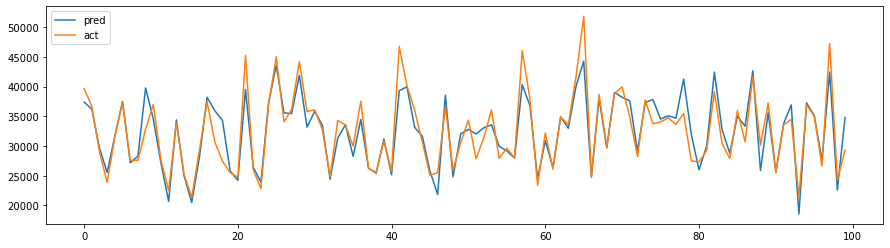

In [9]:
from sklearn.metrics import mean_squared_error

# 予測値の取得
y_pred = model.predict(X_test)

# 二乗平方根で誤差を算出
mse = mean_squared_error(y_test, y_pred)
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))
print("KERAS REG SCORE: %3.2f" % (1.0 - mse ** 0.5 / y_test.mean()))

# 可視化
pd.DataFrame({"pred":y_pred, "act":y_test})[:100].reset_index(drop=True).plot(figsize=(15,4))